In [9]:
%matplotlib inline

from pathlib import Path
import time
import traceback
from importlib import reload

from umap import UMAP
import numpy as np
import scipy.stats as stats
import pandas as pd
pd.set_option('display.max_rows', 50)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', palette='muted')
from matplotlib_venn import venn2, venn3

from TreeMazeAnalyses2.Analyses import subject_info as si

from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from sklearn.covariance import MinCovDet

from matplotlib.patches import Ellipse
import matplotlib.patches as mpatches
import matplotlib.transforms as transforms
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']


In [2]:
%%time
si = reload(si)
subjects = ['Cl']
overwrite = False
for subject in subjects:
    subject_info = si.SubjectInfo(subject, overwrite=overwrite)

CPU times: user 50.7 ms, sys: 11.9 ms, total: 62.6 ms
Wall time: 65 ms


In [ ]:
%%time
#subject_info.update_clusters()

### show #s of curated cell/mua on each tt per session

In [3]:
subject_info.sort_tables['curated']

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Cl_T3g_010218,1,2,1,10,0,0,0,1,0,6,0,0,0,0,1,0
Cl_OF_010218,0,4,1,7,0,0,0,0,0,9,0,1,3,0,1,0
Cl_T3g_010318,0,2,2,2,0,0,0,0,0,4,0,0,0,0,1,0
Cl_OF_010318,0,2,6,3,0,0,0,1,0,8,1,2,0,0,0,1
Cl_OF_010418,0,0,9,8,0,0,0,0,0,6,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cl_T3i_021419,0,6,0,14,0,0,0,0,0,2,0,1,0,0,0,0
Cl_T3g_021519,0,3,0,7,0,0,0,0,0,2,0,0,0,0,0,0
Cl_OF_021519,0,5,0,8,0,0,0,0,0,0,0,0,0,0,0,0
Cl_T3i_021519,0,4,0,7,0,0,0,0,0,0,0,0,0,0,0,0


## within session curation validation
1. select sessions if there are 2 or more 2 isolated units
2. load wfs for those units
3. run analyses: tsne and overlap calculations
4. if there are overalping units, merge those clusters

1-2. Get Data

In [4]:
%%time
n_wf = 1000
n_samps = 32*4

session = 'Cl_OF_010218'

session_cell_IDs = subject_info.session_clusters[session]['cell_IDs']

tetrodes_clusters = {}
for tt, clusters in session_cell_IDs.items():
    if len(clusters)>=2:
        tetrodes_clusters[tt] = clusters

for tt, clusters in tetrodes_clusters.items():
# tt =10
# clusters = tetrodes_clusters[tt]
    X = subject_info.get_session_tt_wf(session, tt, cluster_ids=clusters, n_wf=n_wf)
    n_clusters = len(clusters)
    cluster_labels = np.arange(n_clusters).repeat(n_wf)
    break

CPU times: user 26.7 ms, sys: 165 ms, total: 191 ms
Wall time: 258 ms


In [5]:
tetrodes_clusters

{4: [0, 10, 11, 16], 10: [4, 6, 17]}

## reduce dimensions

In [6]:
def dim_reduction(data, method, random_seed=0, **method_kwargs):
    
    if data.ndim>2:
        raise ValueError("data must be 2 dimensional")
    
    np.random.seed(random_seed)
    
    if method=='tsne':
        default_params = {'n_components': 2, 'perplexity': 20, 'n_jobs': -1}
        for k, v in default_params.items():
            if k not in method_kwargs.keys():
                method_kwargs[k]=v
                
        model = TSNE(**method_kwargs)
        
    elif method=='umap':
        default_params = {'n_components': 2, 'n_neighbors': 30, 'min_dist': 0}
        for k, v in default_params.items():
            if k not in method_kwargs.keys():
                method_kwargs[k]=v
                
        model = UMAP(**method_kwargs)
    
    elif method=='pca':
        default_params = {'n_components': 2}
        for k, v in default_params.items():
            if k not in method_kwargs.keys():
                method_kwargs[k]=v
                
        model = PCA(**method_kwargs)

    return model.fit_transform(data)

In [7]:
%%time
seed=0
method = 'tsne'
X_2d = dim_reduction(data=X.reshape(-1, X.shape[-1]), method=method, random_seed=seed)
plt.scatter(X_2d[:,0], X_2d[:,1], c=np.array(colors)[cluster_labels], alpha=0.3)

CPU times: user 2min 25s, sys: 0 ns, total: 2min 25s
Wall time: 7.8 s


CPU times: user 1min 12s, sys: 1.75 s, total: 1min 13s
Wall time: 12 s


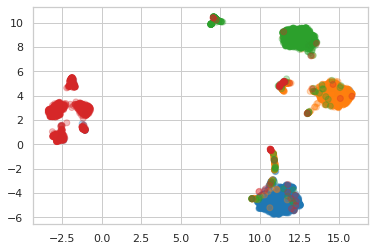

In [10]:
%%time
seed=0
method = 'umap'
X_2d = dim_reduction(data=X.reshape(-1, X.shape[-1]), method=method)
plt.scatter(X_2d[:,0], X_2d[:,1], c=np.array(colors)[cluster_labels], alpha=0.3)

### umap in 3dims

In [11]:
%%time
X_3d = dim_reduction(data=X.reshape(-1, X.shape[-1]), method=method, n_components=3)

CPU times: user 1min 15s, sys: 1.72 s, total: 1min 17s
Wall time: 12.8 s


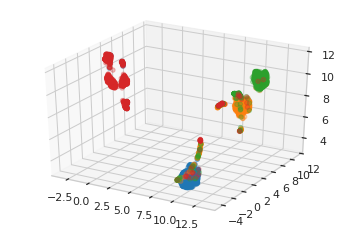

In [12]:
ax = plt.axes(projection='3d') 
ax.scatter3D(X_3d[:,0], X_3d[:,1], X_3d[:,2],c=np.array(colors)[cluster_labels], alpha=0.3)

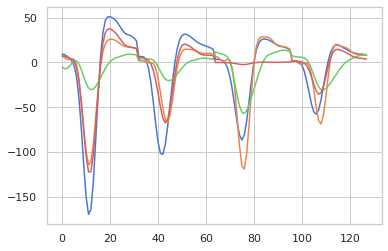

In [13]:
plt.plot(X.mean(axis=1).T)

#### functions to obtain cluster stats

In [14]:

def get_2d_confidence_ellipse(x=None, y=None, n_std=2, n_points=100, mu=None, cov=None, robust_est=True):

    # ref: https://cookierobotics.com/007/

    if (mu is None) and (cov is None):
        mu, cov = estimate_moments(np.array((x,y)),robust_est=False)    
        
    # get eigen values and eigen vectors of covariance
    eig_values, eig_vectors = np.linalg.eig(cov)
    
    # Below we use a parametric formulation for a 2d ellipse 
    
    # parameterized points
    t = np.linspace(0,2*np.pi,n_points)
    v = np.array( [n_std*np.sqrt(eig_values[0])*np.cos(t), 
                   n_std*np.sqrt(eig_values[1])*np.sin(t)] )
    
    # rotation 
    xy = eig_vectors @ v
    
    # translation by coordinate
    xy += mu[:,np.newaxis]
    
    return Polygon(xy.T)

def get_3d_confidence_ellipsoid_surface_points(x=None, y=None, z=None, n_std=2, n_points=100, mu=None, cov=None, robust_est=True):

    # ref: https://cookierobotics.com/007/

    if (mu is None) and (cov is None):
        mu, cov = estimate_moments(np.array( (x,y,z)), robust_est=False)    
        
    # get eigen values and eigen vectors of covariance
    eig_values, eig_vectors = np.linalg.eig(cov)
    
    # get radii
    r = n_std*np.sqrt(eig_values)
    
    # parameterized points
    u = np.linspace(0,2*np.pi,n_points)
    v = np.linspace(0,np.pi,n_points)
    
    x = r[0]*np.outer(np.cos(u), np.sin(v))
    y = r[1]*np.outer(np.sin(u), np.sin(v))
    z = r[2]*np.outer(np.ones_like(u), np.cos(v))

    for i in range(n_points):
        for j in range(n_points):
            [x[i,j],y[i,j],z[i,j]] = np.dot([x[i,j],y[i,j],z[i,j]], eig_vectors) + mu

    return x,y,z

def estimate_moments(X, robust_est=True):
    # compute robust covariance: 
    if robust_est:
        fit = MinCovDet(random_state=0).fit(X)
        cov = fit.covariance_
        mu =  fit.location_
    else:
        cov = np.cov(X.T)
        mu = np.mean(X,axis=0)
        
    return mu, cov

def kld_mvg(m1, s1, m2, s2):
    
    assert m1.shape==m2.shape, "inputs do not match"
    assert s2.shape==s2.shape, "inputs do not match"
    
    if (m1.ndim==1) & (m2.ndim==1):
        k = len(m1)
        m1 = m1[:,np.newaxis]
        m2 = m2[:,np.newaxis]    
    elif (m1.dim==2) & (m2.ndim==2):
        if (m1.shape[1]>1) or (m2.shape[1]>1):
            print("invalid input")
            return np.nan*np.ones(2)
        k = m1.shape[0]
    else:
        print("invalid input")
        return np.nan*np.ones(2)
    
    inv_s1 = np.linalg.inv(s1)
    inv_s2 = np.linalg.inv(s2)
    
    det_s1 = np.linalg.det(s1)
    det_s2 = np.linalg.det(s2)
    
    kld12 = 0.5 * (np.log(det_s2/det_s1) - k + np.trace(inv_s2@s1) + (m2-m1).T @ inv_s2 @ (m2-m1)) / np.log(2)
    kld21 = 0.5 * (np.log(det_s1/det_s2) - k + np.trace(inv_s1@s2) + (m1-m2).T @ inv_s1 @ (m1-m2)) / np.log(2)
    
    return np.array( [kld12.flatten(), kld21.flatten()])

def entropy_mvg(sigma):
    det = np.linalg.det(sigma)
    k = sigma.shape[0]
    return 0.5*(k + k*np.log(2*np.pi) + np.log(det)) / np.log(2)

def get_clusters_moments(data, cluster_labels, robust_est=True):
    cluster_nums = np.unique(cluster_labels)
    k = data.shape[1]
    mu = np.zeros( (n_clusters, k) )
    cov = np.zeros( (n_clusters, k, k) )
    
    for cluster in cluster_nums:
        X = data[cluster_labels==cluster,:]
        mu[cluster], cov[cluster] = estimate_moments(X, robust_est=robust_est)
    return mu, cov

def get_clusters_dists(clusters_mu, clusters_cov, method='kld', **kwargs):
    if clusters_mu.shape[0] != clusters_cov.shape[0]:
        raise ValueError("number of clusters for moments inputs do not match")
    
    n_clusters = clusters_mu.shape[0]
    dist_mat = np.zeros((n_clusters,n_clusters))
    
    if method == 'pe':
        if ('data' in kwargs.keys()) and ('labels' in kwargs.keys()):
            for cl1 in range(n_clusters):
                m = clusters_mu[cl1]
                s = clusters_cov[cl1]
                for cl2 in range(n_clusters):
                    x = kwargs['data'][kwargs['labels']==cl2]
                    dist_mat[cl1, cl2] = mean_samp_prob_gaussian(x, m, s)
            dist_mat = 1 - dist_mat/np.diag(dist_mat)
        else:
            print(f" cond_prob method needs the data samples and cluster labels")
            return None
    else:
        
        if method == 'kld':
            dist_func = kld_mvg
        elif method == 'he':
            dist_func = hellinger_dist_mvg
            
        for cl1 in range(n_clusters-1):
            m1 = clusters_mu[cl1]
            s1 = clusters_cov[cl1]

            for cl2 in range(cl1, n_clusters):
                m2 = clusters_mu[cl2]
                s2 = clusters_cov[cl2]

                dist_mat[cl1, cl2], dist_mat[cl2, cl1] = dist_func(m1,s1,m2,s2)
    
    return dist_mat

def mean_samp_prob_gaussian(x, m, s):
    return stats.multivariate_normal(m, s).pdf(x).mean()
    
def hellinger_dist_1d_gaussians(m1,s1,m2,s2):
    exp_factor = -1/4 * (m1-m2)**2/(s1**2+s**2)
    h2 = 1 - np.sqrt(2*s1*s2/(s1**2+s2**2))*np.exp(exp_factor)
    return np.sqrt(h2)
    
def hellinger_dist_2d_gaussian(m1, s1, m2, s2):
    #https://en.wikipedia.org/wiki/Hellinger_distance
        
    m1 = m1[:,np.newaxis]
    m2 = m2[:,np.newaxis]
    
    s1s2_2 = (s1+s2)/2
    
    det_s1 = np.linalg.det(s1)
    det_s2 = np.linalg.det(s2)
    det_s1s2_2 = np.linalg.det(s1s2_2)
    
    inv_s1s2_2 = np.linalg.inv(s1s2_2)
    
    exp_factor = -1/8*(m1-m2).T @ inv_s1s2_2 @ (m1-m2)
    
    h2 = 1 - (det_s1*det_s2)**(1/4)/(det_s1s2_2)**(1/2) * np.exp(exp_factor)
    h = np.sqrt(h2)

    return np.array([h ,h])

def hellinger_dist_mvg(m1, s1, m2, s2):
    #https://en.wikipedia.org/wiki/Hellinger_distance
        
    assert m1.shape==m2.shape, "inputs do not match"
    assert s2.shape==s2.shape, "inputs do not match"
    
    if (m1.ndim==1) & (m2.ndim==1):
        m1 = m1[:,np.newaxis]
        m2 = m2[:,np.newaxis]    
    elif (m1.dim==2) & (m2.ndim==2):
        if (m1.shape[1]>1) or (m2.shape[1]>1):
            print("invalid input")
            return np.nan*np.ones(2)
    else:
        print("invalid input")
        return np.nan*np.ones(2)
    
    s1s2_2 = (s1+s2)/2
    
    det_s1 = np.linalg.det(s1)
    det_s2 = np.linalg.det(s2)
    det_s1s2_2 = np.linalg.det(s1s2_2)
    
    inv_s1s2_2 = np.linalg.inv(s1s2_2)
    
    exp_factor = -1/8*(m1-m2).T @ inv_s1s2_2 @ (m1-m2)
    
    h2 = 1 - (det_s1*det_s2)**(1/4)/(det_s1s2_2)**(1/2) * np.exp(exp_factor)
    h = np.sqrt(h2)

    return np.array([h ,h])

def get_clusters_entropy(clusters_cov):
    n_clusters = len(clusters_cov)
    
    h = np.zeros(n_clusters)
    for cl in range(n_clusters):
        h[cl] = entropy_mvg(clusters_cov[cl])
        
    return h

def get_clusters_all_dists(clusters_mu, clusters_cov, 
                           data=None, labels=None, 
                           normalize_kld=True, 
                           make_symmetric=True):
    
    n_clusters = len(clusters_mu) 
    dist_metrics = ['he', 'kld', 'pe']
    
    dists_mats = {}
    dists_mats['he'] = get_clusters_dists(clusters_mu, clusters_cov, method='he')
    dists_mats['kld'] = get_clusters_dists(clusters_mu, clusters_cov, method='kld')
    
    if normalize_kld:
        k = clusters_mu.shape[1]  # num data dims
        dists_mats['kld'] /=  entropy_mvg(np.eye(k))
        
    dists_mats['pe'] = get_clusters_dists(clusters_mu, clusters_cov, method='pe', 
                                          data=data, labels=labels)
    
    if make_symmetric:
        for metric in dist_metrics:
            dists_mats[metric] = 0.5*(dists_mats[metric] + dists_mats[metric].T)

    return dists_mats

def plot_2d_cluster_ellipsoids(clusters_mu, clusters_cov, data=None, labels=None, ax=None, legend=False):
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

    cluster_ellipsoids_2md = []
    cluster_ellipsoids_1md = []
    n_clusters = clusters_mu.shape[0]
    
    for cl in range(n_clusters):
        cluster_ellipsoids_2md.append(get_2d_confidence_ellipse(mu=clusters_mu[cl], cov=clusters_cov[cl], n_std=2))
        cluster_ellipsoids_1md.append(get_2d_confidence_ellipse(mu=clusters_mu[cl], cov=clusters_cov[cl], n_std=1))

    if ax is None:
        f, ax = plt.subplots()
    
    label_patch = []
    if data is not None:
        ax.scatter(data[:,0], data[:,1],c=np.array(colors)[cluster_labels], alpha=0.2)
        facecolors = ['grey']*n_clusters
    else:
        facecolors = colors

    
    for cl in range(n_clusters):
        
        patch = PolygonPatch(cluster_ellipsoids_2md[cl], facecolor=facecolors[cl], alpha=0.3)
        ax.add_patch(patch)

        patch = PolygonPatch(cluster_ellipsoids_1md[cl], facecolor=facecolors[cl], alpha=0.5)
        ax.add_patch(patch)

        label_patch.append(mpatches.Patch(color=colors[cl], label='cl'+str(cl), alpha=0.7))

    if legend:
        ax.legend(handles=label_patch, frameon=False, loc=(1.05,0))

    _=ax.axis('scaled')
    return ax

In [27]:
#get_clusters_entropy(clusters_cov). 

[np.linalg.det(s) for s in clusters_cov] 

[0.11184764247769449,
 0.08482647772356855,
 0.0631127941009184,
 0.07527563152509326]

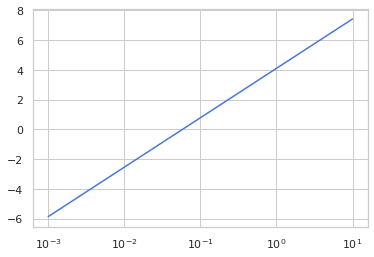

In [82]:
t = np.linspace(10e-4, 10, 5000)
h = [entropy_mvg(tt*np.eye(2)) for tt in t]

plt.semilogx(t,h)



### Estimate empirical mean and covariance & plot confidence ellipsoids

CPU times: user 105 ms, sys: 24 ms, total: 129 ms
Wall time: 95.6 ms


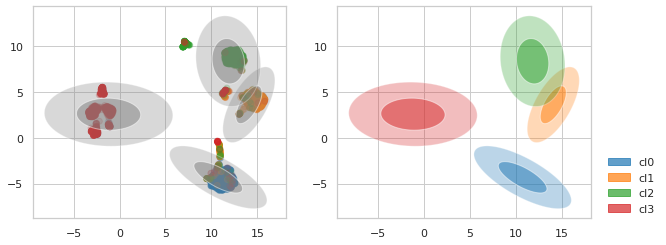

In [20]:
%%time

clusters_mu, clusters_cov = get_clusters_moments(X_2d, cluster_labels, robust_est=False)

f,ax = plt.subplots(1,2, figsize=(10,5))
plot_2d_cluster_ellipsoids(clusters_mu, clusters_cov, X_2d, cluster_labels, ax=ax[0], legend=False)
plot_2d_cluster_ellipsoids(clusters_mu, clusters_cov, ax=ax[1], legend=True)


### Estimate robust covariance & plot ellipsoids

CPU times: user 1.62 s, sys: 84.1 ms, total: 1.71 s
Wall time: 1.71 s


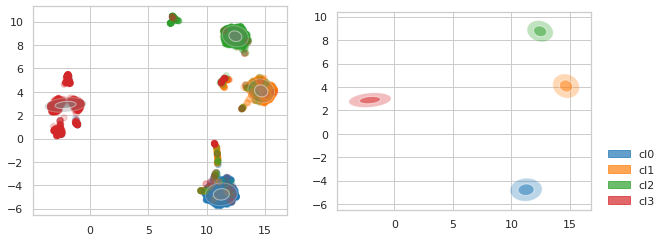

In [21]:
%%time
clusters_mu, clusters_cov = get_clusters_moments(X_2d, cluster_labels, robust_est=True)

f,ax = plt.subplots(1,2, figsize=(10,5))
plot_2d_cluster_ellipsoids(clusters_mu, clusters_cov, X_2d, cluster_labels, ax=ax[0], legend=False)
plot_2d_cluster_ellipsoids(clusters_mu, clusters_cov, ax=ax[1], legend=True)

### for illustration doing it for 3d ellipsoids with robust covariance and without

CPU times: user 2.68 s, sys: 75.1 ms, total: 2.76 s
Wall time: 2.56 s


(3.8030848503112793, 12.308516025543213)

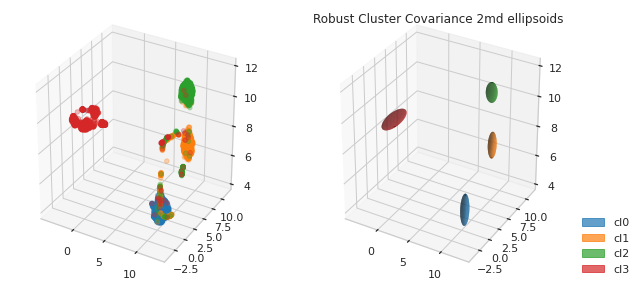

In [63]:
%%time
clusters_mu, clusters_cov = get_clusters_moments(X_3d, cluster_labels, robust_est=True)

cluster_ellipsoids_2md = []
for cl in range(n_clusters):
    cluster_ellipsoids_2md.append(get_3d_confidence_ellipsoid_surface_points(mu=clusters_mu[cl], cov=clusters_cov[cl], n_std=2))
    
f, ax = plt.subplots(1,2, subplot_kw={'projection': '3d'},  figsize=(10,5))
ax[0].scatter3D(X_3d[:,0], X_3d[:,1], X_3d[:,2],c=np.array(colors)[cluster_labels], alpha=0.3)
xlm=ax[0].get_xlim3d() #These are two tupples
ylm=ax[0].get_ylim3d() #we use them in the next
zlm=ax[0].get_zlim3d() #graph to reproduce the magnification from mousing
azm=ax[0].azim
ele=ax[0].elev

label_patch = []
for cl in range(n_clusters):
    X, Y, Z = cluster_ellipsoids_2md[cl]
    #patch = PolygonPatch(cluster_ellipsoids_2md[cl], facecolor=colors[cl], alpha=0.5)
    ax[1].plot_surface(X, Y, Z, linewidth=0, antialiased=True, color = colors[cl], alpha=0.7)
    label_patch.append(mpatches.Patch(color=colors[cl], label='cl'+str(cl), alpha=0.7))
    
ax[1].legend(handles=label_patch, frameon=False, loc=(1.05,0))
ax[1].set_title("Robust Cluster Covariance 2md ellipsoids")

ax[1].view_init(elev=ele, azim=azm) #Reproduce view
ax[1].set_xlim3d(xlm[0],xlm[1])     #Reproduce magnification
ax[1].set_ylim3d(ylm[0],ylm[1])     #...
ax[1].set_zlim3d(zlm[0],zlm[1]) 

CPU times: user 588 ms, sys: 95.7 ms, total: 684 ms
Wall time: 484 ms


(3.8030848503112793, 12.308516025543213)

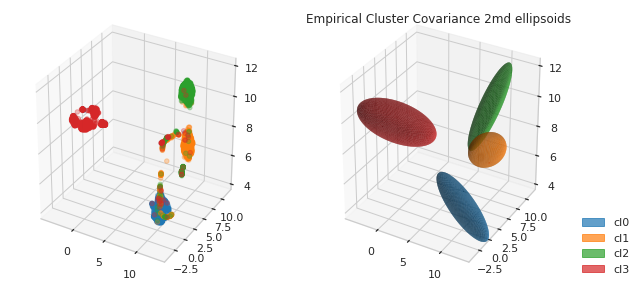

In [64]:
%%time
clusters_mu, clusters_cov = get_clusters_moments(X_3d, cluster_labels, robust_est=False)

cluster_ellipsoids_2md = []
for cl in range(n_clusters):
    cluster_ellipsoids_2md.append(get_3d_confidence_ellipsoid_surface_points(mu=clusters_mu[cl], cov=clusters_cov[cl], n_std=2))
    
f, ax = plt.subplots(1,2, subplot_kw={'projection': '3d'},  figsize=(10,5))
ax[0].scatter3D(X_3d[:,0], X_3d[:,1], X_3d[:,2],c=np.array(colors)[cluster_labels], alpha=0.3)
xlm=ax[0].get_xlim3d() #These are two tupples
ylm=ax[0].get_ylim3d() #we use them in the next
zlm=ax[0].get_zlim3d() #graph to reproduce the magnification from mousing
azm=ax[0].azim
ele=ax[0].elev

label_patch = []
for cl in range(n_clusters):
    X, Y, Z = cluster_ellipsoids_2md[cl]
    #patch = PolygonPatch(cluster_ellipsoids_2md[cl], facecolor=colors[cl], alpha=0.5)
    ax[1].plot_surface(X, Y, Z, linewidth=0, antialiased=True, color = colors[cl], alpha=0.7)
    label_patch.append(mpatches.Patch(color=colors[cl], label='cl'+str(cl), alpha=0.7))
    
ax[1].legend(handles=label_patch, frameon=False, loc=(1.05,0))
ax[1].set_title("Empirical Cluster Covariance 2md ellipsoids")

ax[1].view_init(elev=ele, azim=azm) #Reproduce view
ax[1].set_xlim3d(xlm[0],xlm[1])     #Reproduce magnification
ax[1].set_ylim3d(ylm[0],ylm[1])     #...
ax[1].set_zlim3d(zlm[0],zlm[1]) 

### get KLD dist matrix & cluster entropy

CPU times: user 2.47 s, sys: 59.5 ms, total: 2.53 s
Wall time: 2.45 s


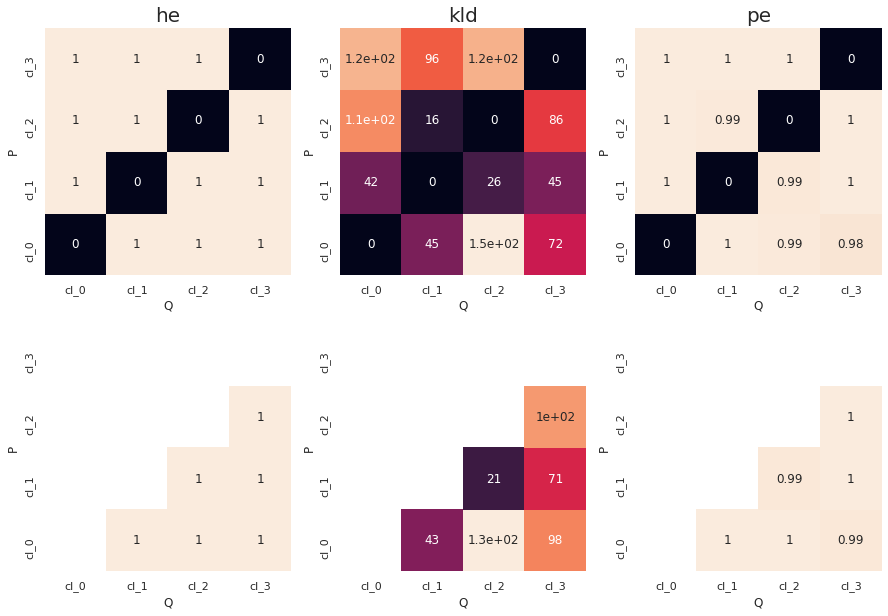

In [185]:
%%time

robust_est=True

if robust_est:
    dist_plot_str = f"clusters_metrics_{session}_{tt}_r.png"
    dist_plot_str2 = f"clusters_metrics_tril_{session}_{tt}_r.png"
else:
    dist_plot_str = f"clusters_metrics_{session}_{tt}.png"
    dist_plot_str2 = f"clusters_metrics_tril_{session}_{tt}.png"

clusters_mu, clusters_cov = get_clusters_moments(X_2d, cluster_labels, robust_est=robust_est)

dists_mats = get_clusters_all_dists(clusters_mu, clusters_cov, data=X_2d, labels=cluster_labels, make_symmetric=False)

metric_names = ['he','kld','pe']
labels = ['cl_'+str(ii) for ii in range(4)]

f, ax = plt.subplots(2,3,figsize=(15,10))
for ii, metric in enumerate(metric_names):
    sns.heatmap(dists_mats[metric], xticklabels=labels, yticklabels=labels, annot=True, ax=ax[0,ii], cbar=False, robust=True)
    ax[0,ii].invert_yaxis()
    ax[0,ii].set_title(metric,fontsize=20)
    ax[0,ii].set_xlabel("Q")
    ax[0,ii].set_ylabel("P")


mask = np.zeros_like(dists_mats['he'])
mask[np.tril_indices_from(mask)] = True
for ii, metric in enumerate(metric_names):
    mat = 0.5*(dists_mats[metric]+dists_mats[metric].T)
    sns.heatmap(mat, mask=mask, xticklabels=labels, yticklabels=labels, annot=True, ax=ax[1,ii], cbar=False, vmin=0)
    ax[1,ii].invert_yaxis()
    ax[1,ii].set_xlabel("Q")
    ax[1,ii].set_ylabel("P")

# fig_path = Path('/home/alexgonzalez/Documents/treemazefigs/misc_figs/')
# f.savefig(fig_path/dist_plot_str, bbox_inches='tight')


## simulation for metrics
Keep 1 standard normal dist and vary the radiuous & sigma of a second dist to understand how these metrics work for different distributions

In [195]:
np.random.seed(0)

n_sim_cl = 2

n_r = 31
r_max = 5

n_sig = 31
sig_max = 4.1

n_points = 2000
mu_0 = np.array([0,0])
sig_0 = np.eye(n_sim_cl)
mvg_0 = stats.multivariate_normal(mu_0, sig_0).rvs(n_points)

r = np.linspace(0,r_max,n_r)
mu_1_set = np.tile(np.sqrt(r**2/2)[:,np.newaxis],n_sim_cl)
sig_1_set = np.linspace(0.1, sig_max, n_sig)

sim_labels = np.arange(n_sim_cl).repeat(n_points)
sim_data = np.zeros((n_points*n_sim_cl, n_sim_cl) )
sim_data[sim_labels==0] = mvg_0

kld = np.zeros((n_r, n_sig))
he = np.zeros((n_r, n_sig))
pe = np.zeros((n_r, n_sig))

for ii, mu_1 in enumerate(mu_1_set):
    for jj, sig_1 in enumerate(sig_1_set):
        mus = np.vstack( (mu_0, mu_1))
        
        sigs = np.zeros((n_sim_cl,2,2))
        sigs[0] = sig_0
        sigs[1] = sig_1**2 * np.eye(n_sim_cl)
        
        mvg_1 = stats.multivariate_normal(mu_1, sig_1).rvs(n_points)
        sim_data[sim_labels==1] = mvg_1
        
        temp = get_clusters_dists(mus, sigs, method='kld') / entropy_mvg(sig_0)
        kld[ii,jj] = 0.5*(temp[0,1]+temp[1,0])
        
        he[ii,jj] = get_clusters_dists(mus, sigs, method='he')[0,1]
        
        temp = get_clusters_dists(mus, sigs, method='pe', data=sim_data, labels=sim_labels)
        pe[ii,jj] = 0.5*(temp[0,1]+temp[1,0])


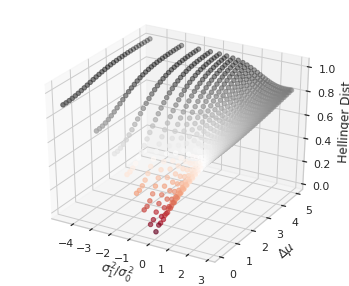

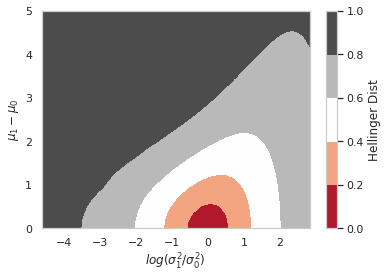

In [205]:
from matplotlib import cm
xx, yy = np.meshgrid(sig_1_set, r)
f, ax = plt.subplots(subplot_kw={'projection':'3d'}, figsize=(6,5))
#ax.plot_surface(xx,yy,he, linewidth=0, antialiased=False, cmap=cm.magma)
ax.scatter(np.log(xx**2), yy, he, c=he, cmap="RdGy")
ax.set_xlabel(r"$\sigma_1^2 / \sigma_0^2$")
ax.set_ylabel(r"$\Delta \mu$")
ax.set_zlabel("Hellinger Dist")

f,ax=plt.subplots()
n_levels = 5
cf = ax.contourf(np.log(xx**2),yy,he, cmap='RdGy', vmax=1.0, levels=5)
cb = plt.colorbar(cf)
ax.set_xlabel(r"$log(\sigma_1^2 / \sigma_0^2)$")
ax.set_ylabel(r"$\mu_1-\mu_0$")
cb.set_label("Hellinger Dist")


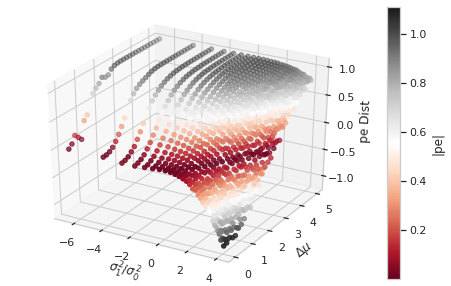

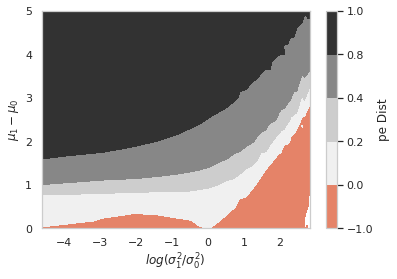

In [220]:
xx, yy = np.meshgrid(sig_1_set, r)
f, ax = plt.subplots(subplot_kw={'projection':'3d'}, figsize=(8,5))
#s=ax.plot_surface(np.log(xx**2),yy,pe, linewidth=0, antialiased=False, cmap=cm.RdGy)
s = ax.scatter(np.log2(xx**2), yy, pe, c=np.abs(pe), cmap="RdGy")
ax.set_xlabel(r"$\sigma_1^2 / \sigma_0^2$")
ax.set_ylabel(r"$\Delta \mu$")
ax.set_zlabel("pe Dist")
cb=plt.colorbar(s)
cb.set_label("|pe|")

f,ax=plt.subplots()
n_levels = 5
cf = ax.contourf(np.log(xx**2),yy,pe, cmap='RdGy', levels=[-1,0,0.2, 0.4,0.8,1])
cb = plt.colorbar(cf)
ax.set_xlabel(r"$log(\sigma_1^2 / \sigma_0^2)$")
ax.set_ylabel(r"$\mu_1-\mu_0$")
cb.set_label("pe Dist")


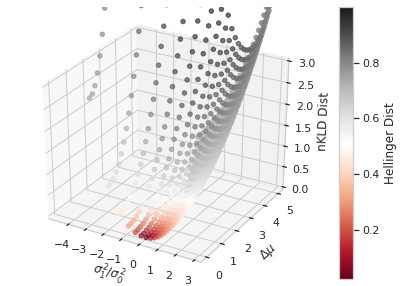

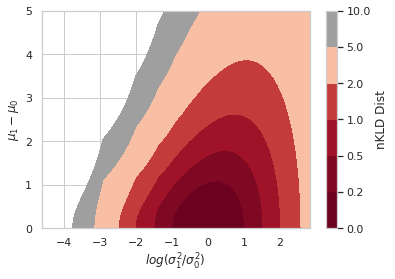

In [222]:
xx, yy = np.meshgrid(sig_1_set, r)
f, ax = plt.subplots(subplot_kw={'projection':'3d'}, figsize=(7,5))
#ax.plot_surface(xx,yy,he, linewidth=0, antialiased=False, cmap=cm.magma)
s=ax.scatter(np.log(xx**2), yy, kld, c=he, cmap="RdGy")
ax.set_xlabel(r"$\sigma_1^2 / \sigma_0^2$")
ax.set_ylabel(r"$\Delta \mu$")
ax.set_zlabel("nKLD Dist")
ax.set_zlim3d([0,3])
cb=plt.colorbar(s)
cb.set_label("Hellinger Dist")

f,ax=plt.subplots()
n_levels = 5
cf = ax.contourf(np.log(xx**2),yy,kld, cmap='RdGy', levels=[0, 0.2, 0.5, 1,2,5,10])
cb = plt.colorbar(cf)
ax.set_xlabel(r"$log(\sigma_1^2 / \sigma_0^2)$")
ax.set_ylabel(r"$\mu_1-\mu_0$")
cb.set_label("nKLD Dist")

(0.0, 3.0)

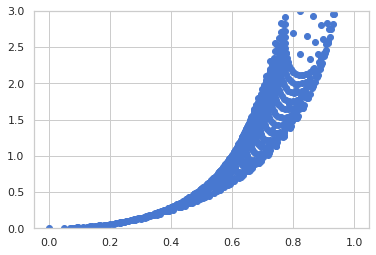

In [152]:
plt.scatter(he.flatten(), kld.flatten())
plt.ylim([0,3])

### observations:
hellinger and kld converge nicely in determining similarity between distributions. However, they do not capture and important aspect. If one distribution is "inside" the other, these measures will still be able to say they are different because of the size of their covariances. However, the pe measure will correctly capture this phenomena, by having the measure be negative. 

### Toy example with dummy data

hellinger
[[0.    0.718 0.388 0.891]
 [0.718 0.    0.923 0.551]
 [0.388 0.923 0.    0.989]
 [0.891 0.551 0.989 0.   ]]

nkld
[[ 0.     1.518  0.328 45.996]
 [ 0.621  0.     2.687  3.608]
 [ 0.143  2.687  0.    73.527]
 [ 1.004  0.336  3.023  0.   ]]

npe
[[ 0.     0.83   0.456  0.977]
 [ 0.662  0.     0.978  0.717]
 [-0.083  0.982  0.     1.   ]
 [ 0.736 -0.546  1.     0.   ]]



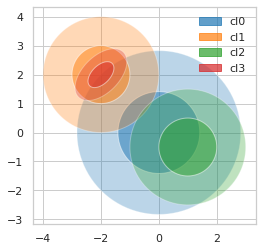

In [224]:
np.random.seed(0)
clusters_mu_dummy = np.array([np.array([0,0]),np.array([-2,2]), np.array([1,-0.5]), np.array([-2,2])])
clusters_cov_dummy = np.array([2*np.eye(2)]+[np.eye(2)]*2+[0.2*np.array( ([1,0.5],[0.5,1]) )])

n_clusters_dummy = len(clusters_mu_dummy)

n_dummy_dat = 1000
dummy_labels = np.arange(n_clusters_dummy).repeat(n_dummy_dat)
dummy_data = np.zeros((len(dummy_labels),2))
for cl in range(n_clusters_dummy):
    dummy_data[dummy_labels==cl]=stats.multivariate_normal(clusters_mu_dummy[cl], clusters_cov_dummy[cl]).rvs(n_dummy_dat)
    
npe = get_clusters_dists(clusters_mu_dummy, clusters_cov_dummy, method='pe', data=dummy_data, labels=dummy_labels)
nkld = get_clusters_dists(clusters_mu_dummy, clusters_cov_dummy, method='kld') / get_clusters_entropy(clusters_cov_dummy)
he = kld = get_clusters_dists(clusters_mu_dummy, clusters_cov_dummy, method='he')
#npe = (np.diag(pe)-pe)/np.diag(pe)

print("hellinger")
print(np.around(he,3))
print()

print('nkld')
print(np.around(nkld,3))
print()

print('npe')
print(np.around(npe,3))
print()

cluster_ellipsoids_2md = []
cluster_ellipsoids_1md = []
for cl in range(len(clusters_mu_dummy)):
    
    
    cluster_ellipsoids_2md.append(get_2d_confidence_ellipse(mu=clusters_mu_dummy[cl], cov=clusters_cov_dummy[cl], n_std=2))
    cluster_ellipsoids_1md.append(get_2d_confidence_ellipse(mu=clusters_mu_dummy[cl], cov=clusters_cov_dummy[cl], n_std=1))
    
f, ax = plt.subplots()
label_patch = []
for cl in range(len(clusters_mu_dummy)):
    #patch = PolygonPatch(cluster_ellipsoids_2md[cl], facecolor=colors[cl], alpha=0.5)
    patch = PolygonPatch(cluster_ellipsoids_2md[cl], facecolor=colors[cl], alpha=0.3)
    ax.add_patch(patch)
    
    patch = PolygonPatch(cluster_ellipsoids_1md[cl], facecolor=colors[cl], alpha=0.5)
    ax.add_patch(patch)
    
    label_patch.append(mpatches.Patch(color=colors[cl], label='cl'+str(cl), alpha=0.7))
    
_=ax.axis('scaled')
ax.legend(handles=label_patch, frameon=False)

In [225]:
np.corrcoef( np.array( (he.flatten(),npe.flatten(), nkld.flatten() )) )

array([[1.        , 0.7957477 , 0.42709067],
       [0.7957477 , 1.        , 0.42212378],
       [0.42709067, 0.42212378, 1.        ]])

In [635]:
fig_path = Path('/home/alexgonzalez/Documents/treemazefigs/misc_figs/')
f.savefig(fig_path/'toy_clusters.png', bbox_inches='tight')

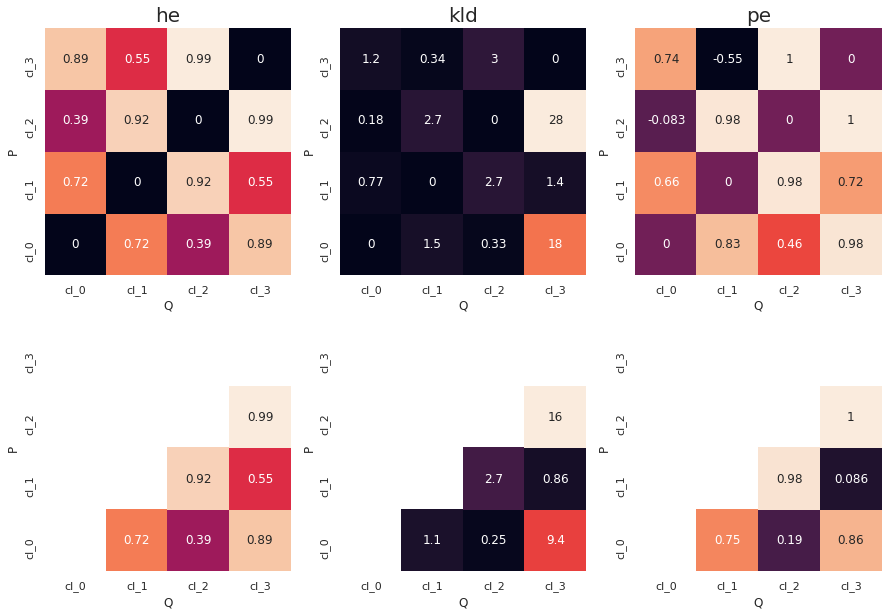

In [226]:
#dists_mats = get_all_cluster_dists(clusters_mu_dummy, clusters_cov_dummy, data=dummy_data, labels=dummy_labels)

dists_mats = get_clusters_all_dists(clusters_mu_dummy, clusters_cov_dummy, data=dummy_data, labels=dummy_labels, make_symmetric=False)

metric_names = ['he','kld','pe']
labels = ['cl_'+str(ii) for ii in range(4)]

f, ax = plt.subplots(2,3,figsize=(15,10))
for ii, metric in enumerate(metric_names):
    sns.heatmap(dists_mats[metric], xticklabels=labels, yticklabels=labels, annot=True, ax=ax[0,ii], cbar=False, robust=True)
    ax[0,ii].invert_yaxis()
    ax[0,ii].set_title(metric,fontsize=20)
    ax[0,ii].set_xlabel("Q")
    ax[0,ii].set_ylabel("P")


mask = np.zeros_like(dists_mats['he'])
mask[np.tril_indices_from(mask)] = True
for ii, metric in enumerate(metric_names):
    mat = 0.5*(dists_mats[metric]+dists_mats[metric].T)
    sns.heatmap(mat, mask=mask, xticklabels=labels, yticklabels=labels, annot=True, ax=ax[1,ii], cbar=False, vmin=0)
    ax[1,ii].invert_yaxis()
    ax[1,ii].set_xlabel("Q")
    ax[1,ii].set_ylabel("P")


fig_path = Path('/home/alexgonzalez/Documents/treemazefigs/misc_figs/')
f.savefig(fig_path/'toy_clusters_metrics_tril.png', bbox_inches='tight')

## see sessions that are matched for depth for a given tetrode

In [245]:
tt = 4
depth = 12.25
subject_info.tt_depth_match[tt][depth]

['Cl_T3g_112318', 'Cl_OF_112318', 'Cl_T3g_112818', 'Cl_OF_112818']

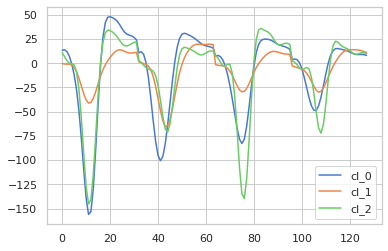

In [230]:
tt=4
session = 'Cl_T3g_010218'
cluster_ids = subject_info.session_clusters[session]['cell_IDs'][tt]
a=subject_info.get_session_tt_wf(session,4, cluster_ids=cluster_ids)
_=plt.plot(a.mean(axis=1).T)
plt.legend(['cl_'+str(ii) for ii in range(3)])


### select cluster match analyses based on isolated cells

In [231]:
%%time
analyses = []
for tt in np.arange(1,17):
    tt_depths = list(subject_info.tt_depth_match[tt].keys())
    for tt_d in tt_depths:
        tt_d_sessions = subject_info.tt_depth_match[tt][tt_d]
        # check if there are more 2 or more sessions with units
        n_cells_session = np.zeros(len(tt_d_sessions),dtype=int)
        for ii, session in enumerate(tt_d_sessions):
            session_cell_IDs = subject_info.session_clusters[session]['cell_IDs']
            if tt in session_cell_IDs.keys():
                n_cells_session[ii] = len(session_cell_IDs[tt])
        sessions_with_cells = np.where(n_cells_session>0)[0]
        if len(sessions_with_cells)>=2:
            analyses.append( (tt, 
                              tt_d, 
                              np.array(tt_d_sessions)[sessions_with_cells].tolist(), 
                              n_cells_session[sessions_with_cells].tolist())
                           )


CPU times: user 7.74 ms, sys: 0 ns, total: 7.74 ms
Wall time: 7.31 ms


In [248]:
tt,d=2,12.25
analysis_id = np.array([(a[0]==tt) & (a[1]==d) for a in analyses]).nonzero()[0][0]
analyses[analysis_id]

(2, 12.25, ['Cl_T3g_112318', 'Cl_OF_112318', 'Cl_T3g_112818'], [1, 1, 3])

In [271]:
n_wf = 1000
n_samps = 32*4
tt, d, sessions, n_session_units = analyses[analysis_id]

X = np.empty((0,n_wf,n_samps),dtype=np.float16)
for session in sessions:
    cluster_ids = subject_info.session_clusters[session]['cell_IDs'][tt]
    session_cell_wf = subject_info.get_session_tt_wf(session, tt, cluster_ids=cluster_ids, n_wf=n_wf)
    X = np.concatenate((X,session_cell_wf),axis=0)

n_clusters = np.array(n_session_units).sum()
cluster_labels = np.arange(n_clusters).repeat(n_wf)
for session_idx, n_session_clusters in enumerate(n_session_units):
    if session_idx==0:
        session_labels = np.zeros(n_session_clusters*n_wf, dtype=int)
    else:
        session_labels = np.concatenate( (session_labels, session_idx*np.ones(n_session_clusters*n_wf )) ).astype(int)

session_clusters_id = [[ii]*session_units for ii,session_units in enumerate(n_session_units)]
session_clusters_id = [item for sublist in session_clusters_id for item in sublist]

label_names =['s'+str(session_clusters_id[cl])+ '_cl'+str(cl) for cl in range(n_clusters)]

In [250]:
print(f' n sessions {len(sessions)} \n n clusters {n_clusters} \n Data Shape {X.shape} \n Clusters Shape {cluster_labels.shape} \n Session Shape {session_labels.shape}') 

 n sessions 3 
 n clusters 5 
 Data Shape (5, 1000, 128) 
 Clusters Shape (5000,) 
 Session Shape (5000,)


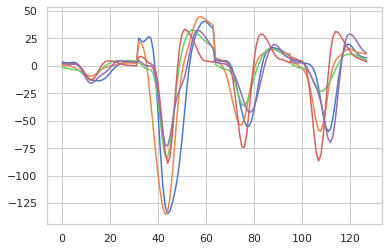

In [251]:
plt.plot(X.mean(axis=1).T)

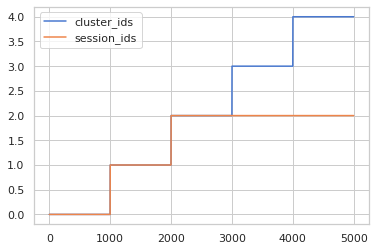

In [252]:
plt.plot(cluster_labels, label = 'cluster_ids')
plt.plot(session_labels, label = 'session_ids')
plt.legend()

In [276]:
def sort_match_analysis_plots(method='umap', robust_cov=True):
    X_2d = dim_reduction(data=X.reshape(-1, X.shape[-1]), method=method)
    clusters_mu, clusters_cov = get_clusters_moments(X_2d, cluster_labels, robust_est=robust_cov)

    f,ax = plt.subplots(1,3, figsize=(16,5))
    plot_2d_cluster_ellipsoids(clusters_mu, clusters_cov, X_2d, cluster_labels, ax=ax[1], legend=False)
    plot_2d_cluster_ellipsoids(clusters_mu, clusters_cov, ax=ax[2], legend=False)
    ax[0].plot(X.mean(axis=1).T, linewidth=2)

    label_patch = []
    for cl in range(n_clusters):
        label_patch.append(mpatches.Patch(color=colors[cl], label=label_names[cl], alpha=0.7))

    ax[2].legend(handles=label_patch, frameon=False, loc=(1.05,0))
    _=ax[2].axis('scaled')

    dists_mats = get_clusters_all_dists(clusters_mu, clusters_cov, data=X_2d, labels=cluster_labels, make_symmetric=False)

    metric_names = ['he','kld','pe']
    labels = ['cl_'+str(ii) for ii in range(4)]

    f, ax = plt.subplots(2,3,figsize=(15,10))
    for ii, metric in enumerate(metric_names):
        sns.heatmap(dists_mats[metric], xticklabels=labels, yticklabels=labels, annot=True, ax=ax[0,ii], cbar=False, robust=True)
        ax[0,ii].invert_yaxis()
        ax[0,ii].set_title(metric,fontsize=20)
        ax[0,ii].set_xlabel("Q")
        ax[0,ii].set_ylabel("P")


    mask = np.zeros_like(dists_mats['he'])
    mask[np.tril_indices_from(mask)] = True
    for ii, metric in enumerate(metric_names):
        mat = 0.5*(dists_mats[metric]+dists_mats[metric].T)
        sns.heatmap(mat, mask=mask, xticklabels=labels, yticklabels=labels, annot=True, ax=ax[1,ii], cbar=False, vmin=0, vmax=1)
        ax[1,ii].invert_yaxis()
        ax[1,ii].set_xlabel("Q")
        ax[1,ii].set_ylabel("P")
        
def sort_match_analysis(method='umap', robust_cov=True):
    X_2d = dim_reduction(data=X.reshape(-1, X.shape[-1]), method=method)
    clusters_mu, clusters_cov = get_clusters_moments(X_2d, cluster_labels, robust_est=robust_cov)
    dists_mats = get_clusters_all_dists(clusters_mu, clusters_cov, data=X_2d, labels=cluster_labels, make_symmetric=True)
    return dist_mats

## Apply dim_reduc to the waveforms & explore differences umap & tsne and different covariance estimations

CPU times: user 1min 31s, sys: 3.26 s, total: 1min 34s
Wall time: 10.1 s


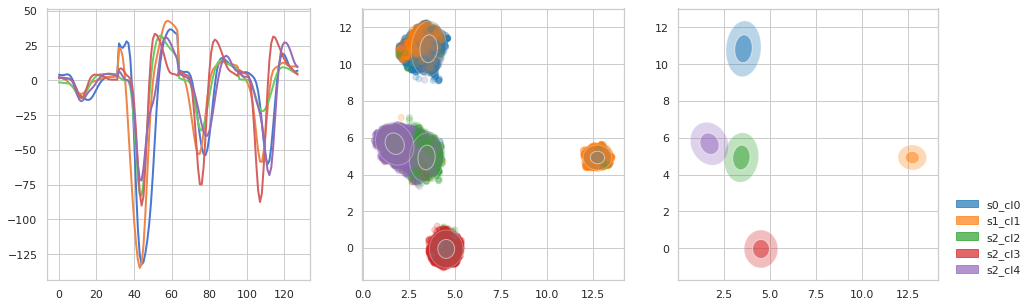

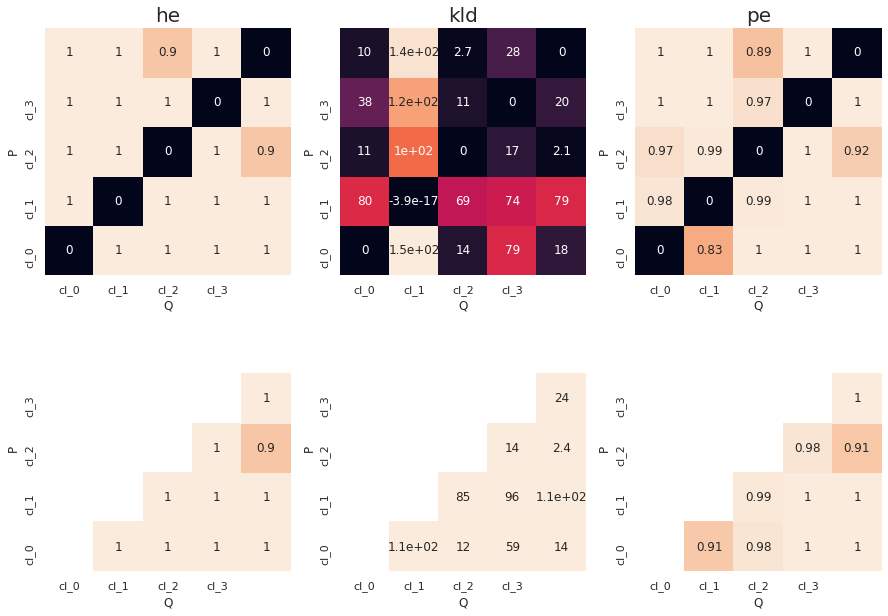

In [280]:
%%time
seed=0
method = 'umap'
robust_cov = True
sort_match_analysis_plots(method=method, robust_cov=robust_cov)

/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel_launcher.py:205: RuntimeWarning: invalid value encountered in sqrt


CPU times: user 1min 52s, sys: 3.29 s, total: 1min 55s
Wall time: 9.33 s


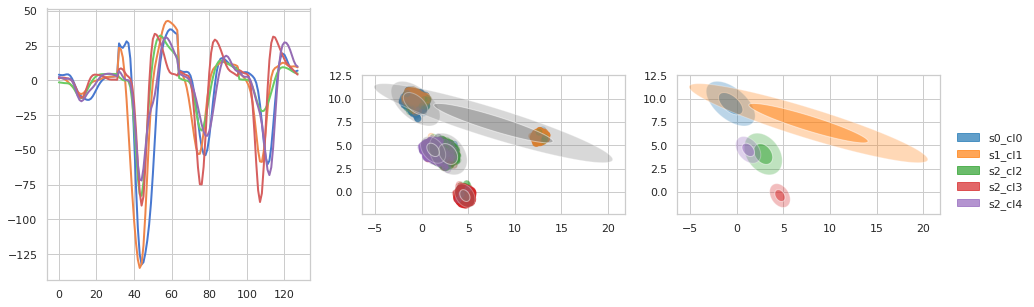

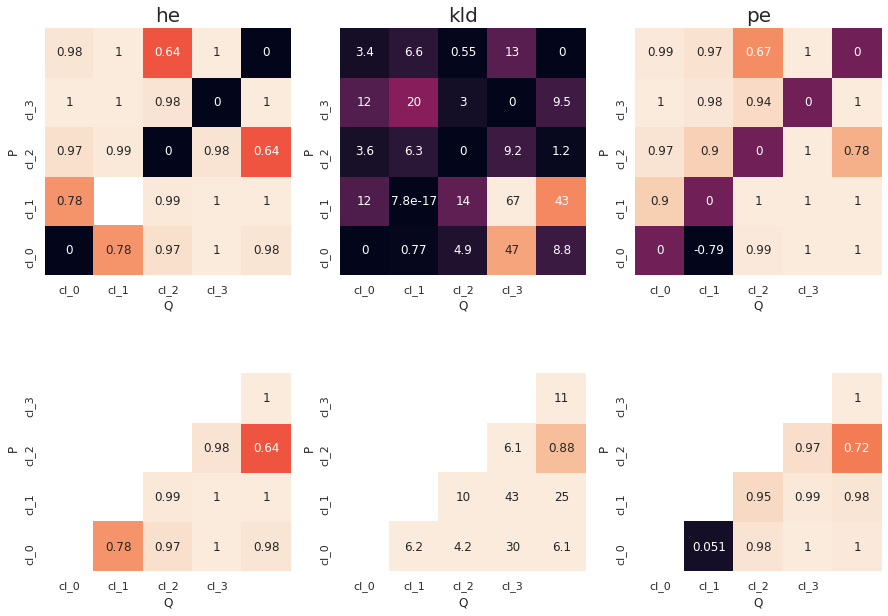

In [277]:
%%time
method = 'umap'
robust_cov = False
sort_match_analysis_plots(method=method, robust_cov=robust_cov)

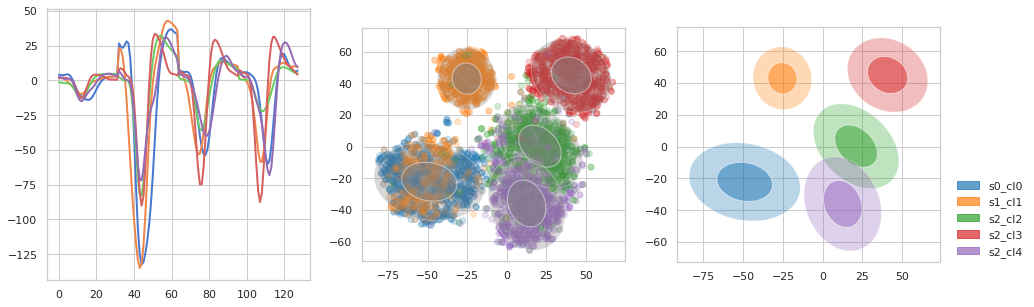

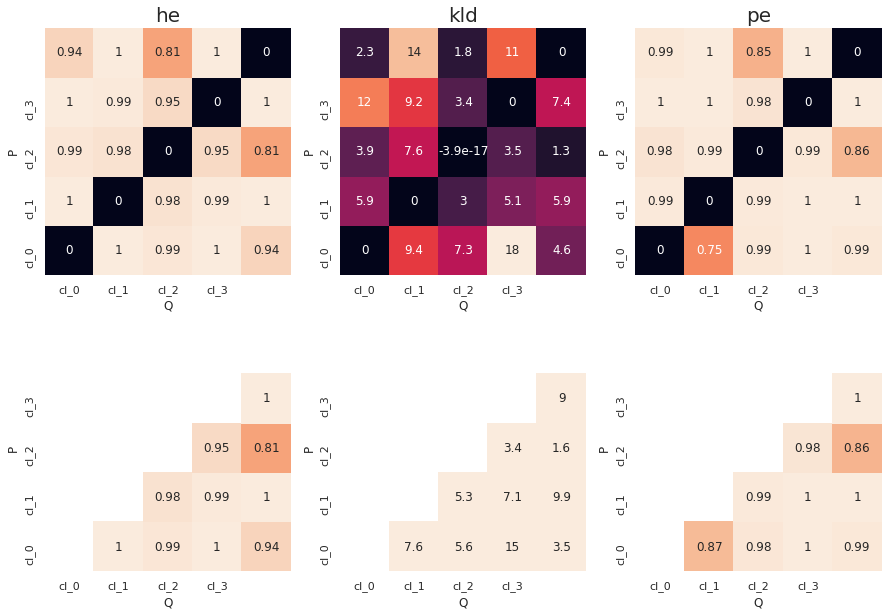

In [278]:
method = 'tsne'
robust_cov = True
sort_match_analysis_plots(method=method, robust_cov=robust_cov)

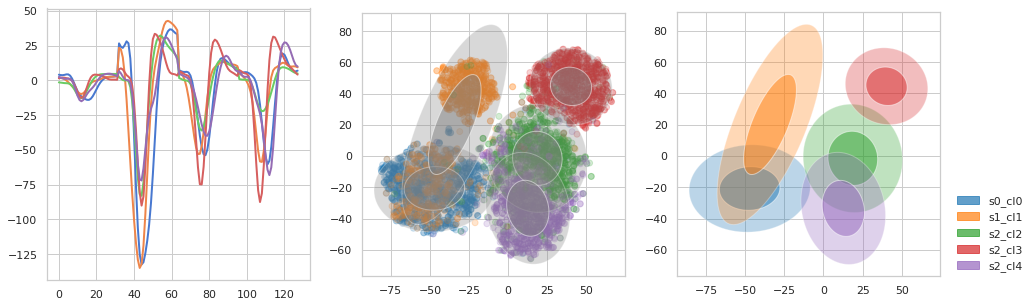

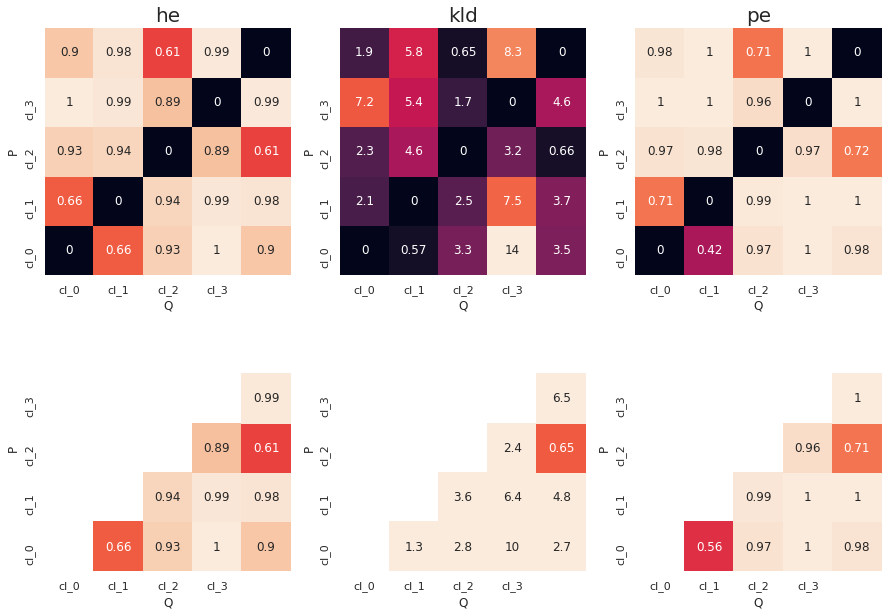

In [279]:
method = 'tsne'
robust_cov = False
sort_match_analysis_plots(method=method, robust_cov=robust_cov)

In [742]:
fig_path = Path('/home/alexgonzalez/Documents/treemazefigs/misc_figs/')
f.savefig(fig_path/f"cluster_sesssion_match_{subject}_{analyses_id}.png", bbox_inches='tight')

## iterate over all analyses [tt, depth]

In [334]:
%%time

n_wf = 1000
n_samps = 32*4
method = 'tsne'
robust_cov = True

dists_metrics = ['he', 'kld', 'pe']
analyses = []
for tt in np.arange(1,17):
    tt_depths = list(subject_info.tt_depth_match[tt].keys())
    for tt_d in tt_depths:
        tt_d_sessions = subject_info.tt_depth_match[tt][tt_d]
        # check if there are more 2 or more sessions with units
        n_cells_session = np.zeros(len(tt_d_sessions),dtype=int)
        for ii, session in enumerate(tt_d_sessions):
            session_cell_IDs = subject_info.session_clusters[session]['cell_IDs']
            if tt in session_cell_IDs.keys():
                n_cells_session[ii] = len(session_cell_IDs[tt])
        sessions_with_cells = np.where(n_cells_session>0)[0]
        if len(sessions_with_cells)>=2:
            analyses.append( (tt, 
                              tt_d, 
                              np.array(tt_d_sessions)[sessions_with_cells].tolist(), 
                              n_cells_session[sessions_with_cells].tolist())
                           )

sort_match_analyses_dists_mats = []
for analysis_id, analysis in enumerate(analyses):
    t0 = time.time()

    tt, d, sessions, n_session_units = analysis
    
    # get data
    X = np.empty((0,n_wf,n_samps),dtype=np.float16)
    for session in sessions:
        cluster_ids = subject_info.session_clusters[session]['cell_IDs'][tt]
        session_cell_wf = subject_info.get_session_tt_wf(session, tt, cluster_ids=cluster_ids, n_wf=n_wf)
        X = np.concatenate((X,session_cell_wf),axis=0)
        

    # get label ids
    n_clusters = np.array(n_session_units).sum()
    cluster_labels = np.arange(n_clusters).repeat(n_wf)
    for session_idx, n_session_clusters in enumerate(n_session_units):
        if session_idx==0:
            session_labels = np.zeros(n_session_clusters*n_wf, dtype=int)
        else:
            session_labels = np.concatenate( (session_labels, session_idx*np.ones(n_session_clusters*n_wf )) ).astype(int)
            
    session_clusters_id = [[ii]*session_units for ii,session_units in enumerate(n_session_units)]
    session_clusters_id = [item for sublist in session_clusters_id for item in sublist]
    
    label_names = []
    for session in range(len(sessions)):
        for cl in range(n_session_units[session]):
            label_names.append(f"s{session}_cl{cl}")

    # perform clustering analysis
    X_2d = dim_reduction(data=X.reshape(-1, X.shape[-1]), method=method)
    clusters_mu, clusters_cov = get_clusters_moments(X_2d, cluster_labels, robust_est=robust_cov)
    dists_mats = get_clusters_all_dists(clusters_mu, clusters_cov, data=X_2d, labels=cluster_labels, make_symmetric=True)

    dists_mats2 = {}
    # append names
    for metric in dists_metrics:
        dists_mats2[metric] =  pd.DataFrame(dists_mats[metric], index=label_names,columns=label_names)
    
    sort_match_analyses_dists_mats.append(dists_mats2)
    
    t1 = time.time()
    print(f"analysis {analysis_id} completed, n_clusters = {n_clusters}, n_sessions = {len(sessions)}, t={(t1-t0):0.2f}")


analysis 0 completed, n_clusters = 2, n_sessions = 2, t=4.26
analysis 1 completed, n_clusters = 2, n_sessions = 2, t=4.97
analysis 2 completed, n_clusters = 7, n_sessions = 2, t=16.26
analysis 3 completed, n_clusters = 5, n_sessions = 3, t=10.16
analysis 4 completed, n_clusters = 15, n_sessions = 5, t=37.22
analysis 5 completed, n_clusters = 16, n_sessions = 6, t=40.21
analysis 6 completed, n_clusters = 7, n_sessions = 4, t=15.13
analysis 7 completed, n_clusters = 7, n_sessions = 4, t=19.04
analysis 8 completed, n_clusters = 4, n_sessions = 4, t=9.49
analysis 9 completed, n_clusters = 3, n_sessions = 2, t=6.54
analysis 10 completed, n_clusters = 3, n_sessions = 3, t=6.77


/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel_launcher.py:205: RuntimeWarning: invalid value encountered in sqrt


analysis 11 completed, n_clusters = 35, n_sessions = 10, t=107.62
analysis 12 completed, n_clusters = 5, n_sessions = 2, t=11.47
analysis 13 completed, n_clusters = 3, n_sessions = 2, t=7.00


/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel_launcher.py:205: RuntimeWarning: invalid value encountered in sqrt


analysis 14 completed, n_clusters = 32, n_sessions = 8, t=105.36
analysis 15 completed, n_clusters = 37, n_sessions = 10, t=126.16


/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel_launcher.py:205: RuntimeWarning: invalid value encountered in sqrt


analysis 16 completed, n_clusters = 13, n_sessions = 5, t=33.07
analysis 17 completed, n_clusters = 6, n_sessions = 3, t=12.85
analysis 18 completed, n_clusters = 10, n_sessions = 4, t=23.43
analysis 19 completed, n_clusters = 9, n_sessions = 4, t=22.86
analysis 20 completed, n_clusters = 8, n_sessions = 3, t=19.22
analysis 21 completed, n_clusters = 7, n_sessions = 3, t=14.73


/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel_launcher.py:205: RuntimeWarning: invalid value encountered in sqrt


analysis 22 completed, n_clusters = 18, n_sessions = 6, t=48.18


/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel_launcher.py:205: RuntimeWarning: invalid value encountered in sqrt


analysis 23 completed, n_clusters = 9, n_sessions = 3, t=20.14
analysis 24 completed, n_clusters = 7, n_sessions = 4, t=15.65
analysis 25 completed, n_clusters = 8, n_sessions = 3, t=17.99


/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel_launcher.py:205: RuntimeWarning: invalid value encountered in sqrt


analysis 26 completed, n_clusters = 16, n_sessions = 5, t=41.82
analysis 27 completed, n_clusters = 9, n_sessions = 3, t=21.31
analysis 28 completed, n_clusters = 24, n_sessions = 7, t=66.90


/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel_launcher.py:205: RuntimeWarning: invalid value encountered in sqrt


analysis 29 completed, n_clusters = 10, n_sessions = 2, t=20.93
analysis 30 completed, n_clusters = 4, n_sessions = 2, t=8.88
analysis 31 completed, n_clusters = 5, n_sessions = 3, t=11.70
analysis 32 completed, n_clusters = 7, n_sessions = 2, t=15.24
analysis 33 completed, n_clusters = 3, n_sessions = 2, t=6.88
analysis 34 completed, n_clusters = 2, n_sessions = 2, t=5.27


/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel_launcher.py:205: RuntimeWarning: invalid value encountered in sqrt


analysis 35 completed, n_clusters = 17, n_sessions = 9, t=45.35
analysis 36 completed, n_clusters = 3, n_sessions = 2, t=6.12
analysis 37 completed, n_clusters = 6, n_sessions = 3, t=12.83


/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel_launcher.py:205: RuntimeWarning: invalid value encountered in sqrt


analysis 38 completed, n_clusters = 33, n_sessions = 14, t=92.07
analysis 39 completed, n_clusters = 19, n_sessions = 9, t=46.51
analysis 40 completed, n_clusters = 7, n_sessions = 4, t=16.24
analysis 41 completed, n_clusters = 6, n_sessions = 4, t=14.22
analysis 42 completed, n_clusters = 8, n_sessions = 4, t=19.07
analysis 43 completed, n_clusters = 7, n_sessions = 3, t=16.89
analysis 44 completed, n_clusters = 7, n_sessions = 3, t=14.83


/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel_launcher.py:205: RuntimeWarning: invalid value encountered in sqrt


analysis 45 completed, n_clusters = 13, n_sessions = 6, t=31.14


/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel_launcher.py:205: RuntimeWarning: invalid value encountered in sqrt


analysis 46 completed, n_clusters = 7, n_sessions = 3, t=15.03


/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel_launcher.py:205: RuntimeWarning: invalid value encountered in sqrt


analysis 47 completed, n_clusters = 14, n_sessions = 7, t=34.62
analysis 48 completed, n_clusters = 5, n_sessions = 2, t=10.17
analysis 49 completed, n_clusters = 8, n_sessions = 3, t=17.11


/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel_launcher.py:205: RuntimeWarning: invalid value encountered in sqrt


analysis 50 completed, n_clusters = 27, n_sessions = 8, t=79.73


/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel_launcher.py:205: RuntimeWarning: invalid value encountered in sqrt


analysis 51 completed, n_clusters = 37, n_sessions = 10, t=133.74
analysis 52 completed, n_clusters = 15, n_sessions = 5, t=36.32
analysis 53 completed, n_clusters = 5, n_sessions = 2, t=10.88
analysis 54 completed, n_clusters = 4, n_sessions = 3, t=10.19
CPU times: user 6h 58min 56s, sys: 1min 24s, total: 7h 20s
Wall time: 26min 57s


In [295]:
unit_counts = 0
unit_overlap_count = 0

for analysis, dists  in enumerate(sort_match_analyses_dists_mats):
    

[{'he': array([[0., 1.],
         [1., 0.]]),
  'kld': array([[ 0.        , 75.37696576],
         [75.37696576,  0.        ]]),
  'pe': array([[0.        , 0.99657293],
         [0.99657293, 0.        ]])},
 {'he': array([[0., 1.],
         [1., 0.]]),
  'kld': array([[  0.        , 102.46673768],
         [102.46673768,   0.        ]]),
  'pe': array([[0., 1.],
         [1., 0.]])},
 {'he': array([[0.        , 1.        , 0.99748436, 1.        , 0.99984314,
          0.99970182, 1.        ],
         [1.        , 0.        , 1.        , 0.36703064, 1.        ,
          1.        , 0.18031563],
         [0.99748436, 1.        , 0.        , 1.        , 0.98807619,
          0.99142691, 1.        ],
         [1.        , 0.36703064, 1.        , 0.        , 1.        ,
          1.        , 0.52959577],
         [0.99984314, 1.        , 0.98807619, 1.        , 0.        ,
          0.71937071, 1.        ],
         [0.99970182, 1.        , 0.99142691, 1.        , 0.71937071,
          0

In [305]:

sort_match_analyses_dists_mats[4]['he'].shape[0], len(np.where(sort_match_analyses_dists_mats[4]['he']<0.5)[0])

(15, 19)

In [322]:
pp = pd.DataFrame(dists_mats['pe'], index=label_names,columns=label_names)
pp

,s0_cl0,s1_cl1,s1_cl2,s2_cl3
s0_cl0,0.000000,0.604794,0.034785,0.999983
s1_cl1,0.604794,0.000000,0.631532,0.999767
s1_cl2,0.034785,0.631532,0.000000,0.999311
s2_cl3,0.999983,0.999767,0.999311,0.000000


In [328]:
label_names = []
for session in range(3):
    for cl in range(n_session_units[session]):
        label_names.append(f"s{session}_cl{cl}")
label_names


['s0_cl0', 's1_cl0', 's1_cl1', 's2_cl0']

In [326]:
np.arange(n_session_units[0])

array([0])

In [321]:

n_sessions=3
session_ids = np.arange(n_sessions)

unique_matches = 0
for s1 in np.arange(n_sessions-1):
    for s2 in np.arange(s1+1,n_sessions) 
        for cl in n_session_units[s1]:
            
        
        for s in range

array([0.78516747, 0.20220122, 0.80745949, 1.        , 1.        ,
       1.        ])